In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import matplotlib.pyplot as plt
import numpy as np
import os
# import pandas as pd

2023-06-28 10:34:53.129711: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Dataset preparation

### Set parameters

In [2]:
batch_size = 32
img_height = 184
img_width = 216
img_size = (img_height, img_width)
img_shape = img_size + (3,)

### Load dataset

In [3]:
from tensorflow.keras.utils import image_dataset_from_directory

train_path = "../dataset_1/training"
val_path = "../dataset_1/validation"

with tf.device("CPU"):
    train_ds = image_dataset_from_directory(train_path,
                                        seed = 123,
                                        image_size = img_size,
                                        batch_size = batch_size)
    
    val_ds = image_dataset_from_directory(val_path,
                                      seed = 456,
                                      image_size = img_size,
                                      batch_size = batch_size)

2023-06-28 10:34:55.116935: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-28 10:34:55.519312: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1637] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7910 MB memory:  -> device: 0, name: A100-SXM4-40GB MIG 2g.10gb, pci bus id: 0000:90:00.0, compute capability: 8.0


Found 17126 files belonging to 3 classes.
Found 4282 files belonging to 3 classes.


In [4]:
class_names = train_ds.class_names
num_classes = len(class_names)

print(class_names)

['bipolar_disorder', 'healthy_controls', 'schizophrenia']


### Test set

In [5]:
with tf.device("CPU"):
    AUTOTUNE = tf.data.AUTOTUNE
    val_batches = tf.data.experimental.cardinality(val_ds)
    test_dataset = val_ds.take(val_batches // 2)
    validation_dataset = val_ds.skip(val_batches // 2)
    
    # Buffered prefetching
    train_dataset = train_ds.prefetch(buffer_size = AUTOTUNE)
    validation_dataset = validation_dataset.prefetch(buffer_size = AUTOTUNE)
    test_dataset = test_dataset.prefetch(buffer_size = AUTOTUNE)

In [6]:
print(len(validation_dataset))
print(len(test_dataset))

67
67


## Model building

In [7]:
def lenet(dropout_num):
    model = Sequential([
    Conv2D(8, (3, 3), activation='relu', input_shape=img_shape),
    Dropout(dropout_num),
    MaxPooling2D((2, 2)),
        
    Conv2D(16, (3, 3), activation='relu'),
    Dropout(dropout_num),
    MaxPooling2D((2, 2)),
    MaxPooling2D((2, 2)),   
        
    Flatten(),
    Dense(32, activation='relu'),
    Dense(32, activation='relu'),
#     Dropout(dropout_num),
    Dense(3, activation='softmax')
])
    return model

In [8]:
with tf.device("GPU"):
    model = lenet(0.2)

    # compile model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-3),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
                  metrics=['accuracy'])

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 182, 214, 8)       224       
                                                                 
 dropout (Dropout)           (None, 182, 214, 8)       0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 91, 107, 8)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 89, 105, 16)       1168      
                                                                 
 dropout_1 (Dropout)         (None, 89, 105, 16)       0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 44, 52, 16)       0         
 2D)                                                    

## Model training

In [10]:
# Callback function
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy')>0.95):
            print("\nReached 95% accuracy, cancelling training")
            self.model.stop_training = True
            
callbacks = myCallback()
save_locally = tf.saved_model.SaveOptions(experimental_io_device='/job:localhost')
checkpoints_cb = tf.keras.callbacks.ModelCheckpoint('./cnn1_checkpoints', options=save_locally)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4)

In [11]:
EPOCH = 150

history = model.fit(
            train_dataset,
            validation_data = validation_dataset,
            epochs = EPOCH,
            batch_size = 32,
            callbacks=[callbacks])

Epoch 1/150


2023-06-28 10:34:58.247316: I tensorflow/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-06-28 10:34:58.955771: I tensorflow/stream_executor/cuda/cuda_blas.cc:1633] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


536/536 [==============================] - 11s 15ms/step - loss: 1.5360 - accuracy: 0.5441 - val_loss: 1.0430 - val_accuracy: 0.5318
Epoch 2/150
536/536 [==============================] - 8s 15ms/step - loss: 0.8036 - accuracy: 0.6495 - val_loss: 1.1029 - val_accuracy: 0.4949
Epoch 3/150
536/536 [==============================] - 8s 15ms/step - loss: 0.6883 - accuracy: 0.7031 - val_loss: 1.1395 - val_accuracy: 0.4878
Epoch 4/150
536/536 [==============================] - 8s 15ms/step - loss: 0.5972 - accuracy: 0.7503 - val_loss: 1.2529 - val_accuracy: 0.4509
Epoch 5/150
536/536 [==============================] - 8s 15ms/step - loss: 0.5370 - accuracy: 0.7783 - val_loss: 1.3365 - val_accuracy: 0.4860
Epoch 6/150
536/536 [==============================] - 8s 15ms/step - loss: 0.4753 - accuracy: 0.8060 - val_loss: 1.3938 - val_accuracy: 0.4804
Epoch 7/150
536/536 [==============================] - 8s 15ms/step - loss: 0.4141 - accuracy: 0.8353 - val_loss: 1.4909 - val_accuracy: 0.4065
Epo

### Training evaluation

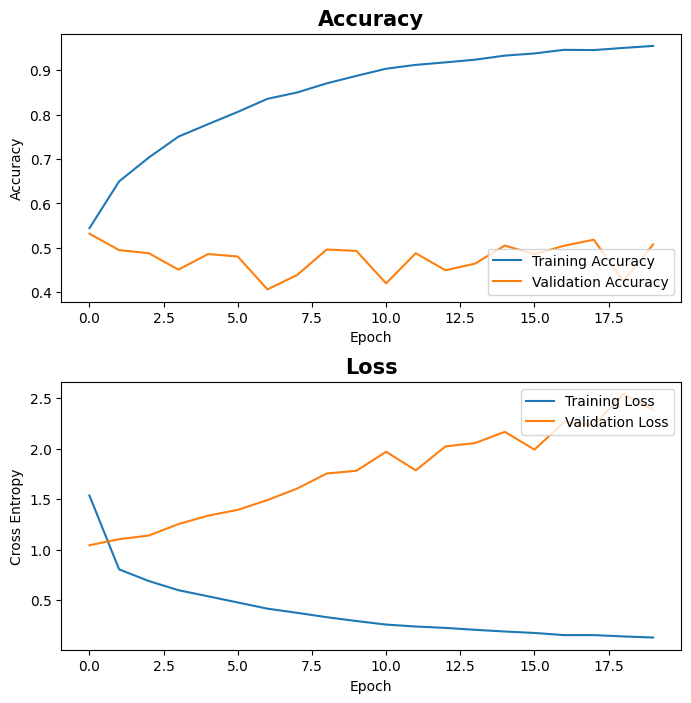

In [12]:
plt.figure(figsize=(8, 8))

# training and validation accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
# plt.ylim([min(plt.ylim()),1])
plt.title('Accuracy', size=15, fontweight='bold')

# training and validation loss
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.xlabel('Epoch')
# plt.ylim([0,1.0])
plt.title('Loss', size=15, fontweight='bold')

plt.subplots_adjust(hspace=0.3)
plt.show()

## Testing

In [13]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score
import seaborn as sns

In [14]:
result = model.evaluate(test_dataset)
dict(zip(model.metrics_names, result))

67/67 [==============================] - 1s 7ms/step - loss: 2.2427 - accuracy: 0.5187


{'loss': 2.2427380084991455, 'accuracy': 0.5186567306518555}

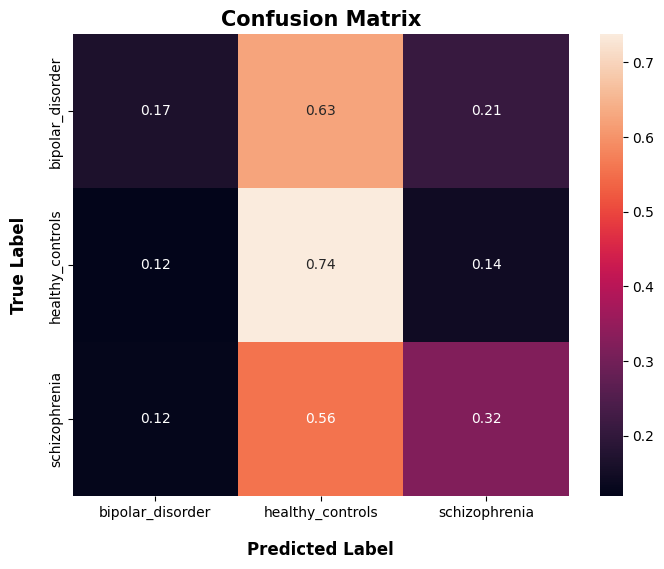

In [15]:
predicted = []  # predicted labels
true = []  # true labels

for image_batch, label_batch in test_dataset:  
    true.append(label_batch)
    prediction = model.predict(image_batch, verbose=0)
    predicted.append(np.argmax(prediction, axis=-1))

# convert labels into tensors
true_labels = tf.concat([item for item in true], axis=0)
predicted_labels = tf.concat([item for item in predicted], axis=0)

cf_matrix = confusion_matrix(true_labels, predicted_labels, normalize='true')

# plot confusion  matrix
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
sns.heatmap(cf_matrix, 
            annot=True)
ax.xaxis.set_ticklabels(class_names)
ax.yaxis.set_ticklabels(class_names)
plt.xlabel('Predicted Label', labelpad=15, size=12, fontweight='bold')
plt.ylabel('True Label', labelpad=15, size=12, fontweight='bold')
plt.title('Confusion Matrix', size=15, fontweight='bold')
plt.savefig('./lenet1_cm.png')
plt.show()

In [16]:
precision = precision_score(true_labels, predicted_labels, average='weighted')
sensitivity = recall_score(true_labels, predicted_labels, average='weighted')
specificity = []
for i in range(num_classes):
    true_negatives = np.sum(np.delete(np.delete(cf_matrix, i, axis=0), i, axis=1))
    false_positives = np.sum(cf_matrix[:, i]) - cf_matrix[i, i]
    specificity.append(true_negatives / (true_negatives + false_positives))

# Calculate average specificity
average_specificity = np.mean(specificity)

print("Accuracy:", result[1])
print("Precision:", precision)
print("Sensitivity:", sensitivity)
print("Specificity:", average_specificity)

Accuracy: 0.5186567306518555
Precision: 0.48915413311236305
Sensitivity: 0.5242537313432836
Specificity: 0.7038015961685846
